In [33]:
# Run some setup code for this notebook.

import random
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from __future__ import print_function

import cv2

import scipy
from scipy import ndimage

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
layer_name = 'VIIRS_SNPP_CorrectedReflectance_TrueColor'
img_extension = ".jpg"
data_dir = 'data/4326/'
labels_file = os.path.join(data_dir, layer_name + ".txt")
img_size = (2048, 1024)

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_val, y_val
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

def parse_labels(label_arr):
    """    
    None = Normal
    1 = missing data (expected)
    2 = missing data (unexpected)
    3 = miscoloration
    4 = edge warping
    5 = eclipse (missing data)
    6 = eclipse (only miscoloration)
    """
    label = 0
    if len(label_arr) == 0:
        label = 0
    else:
        if 1 in label_arr or 2 in label_arr or 5 in label_arr:
            label = 1
        else:
            label = 0
    return label

def get_data(root_path, labels_file, split = ""):
    # Validate the file directory
    assert os.path.exists(labels_file), "Cannot find the {} file".format(layer_name + ".txt")
    
    # Build up the filenames and labels
    train_images = []
    val_images = []
    test_images = []
    
    train_labels = []
    val_labels = []
    test_labels = []
    
    # Read in the file line by line
    img_counter = 0
    with open(labels_file) as f:
        file_lines = f.read().splitlines()
        num_total_img = len(file_lines)
        for line in file_lines:
            line_list = line.split()  
            split = line_list[0]
            datestring = line_list[1]
            label_arr = [int(item) for item in line_list[2:]]
            label = parse_labels(label_arr)
            
            # Construct and resize the image
            filename = os.path.join(root_path, datestring, layer_name + img_extension)
            image = Image.open(filename)
            image = image.resize(img_size, Image.BILINEAR)
            image = np.asarray(image)
            
            # Grayscale and black and white the image!
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV)            
            
            if split == 'train':
                train_images.append(image)
                train_labels.append(label)
            elif split == 'val':
                val_images.append(image)
                val_labels.append(label)
            else:
                test_images.append(image)
                test_labels.append(label)
            
            img_counter += 1
            if img_counter % 100 == 0:
                print('Loaded {} / {} images'.format(img_counter, num_total_img))
    
    X_train = np.array(train_images)
    y_train = np.array(train_labels)

    X_val = np.array(val_images)
    y_val = np.array(val_labels)
    
    X_test = np.array(test_images)
    y_test = np.array(test_labels)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_data(data_dir, labels_file)

# # Save for later analysis
orig_X_train = X_train
orig_X_val = X_val

# # As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Loaded 100 / 946 images
Loaded 200 / 946 images
Loaded 300 / 946 images
Loaded 400 / 946 images
Loaded 500 / 946 images
Loaded 600 / 946 images
Loaded 700 / 946 images
Loaded 800 / 946 images
Loaded 900 / 946 images
Training data shape:  (567, 1024, 2048)
Training labels shape:  (567,)
Validation data shape:  (189, 1024, 2048)
Validation labels shape:  (189,)
Test data shape:  (190, 1024, 2048)
Test labels shape:  (190,)


## Visualize Examples
Visualize some examples from the training dataset. We show a few examples of training images from each class.

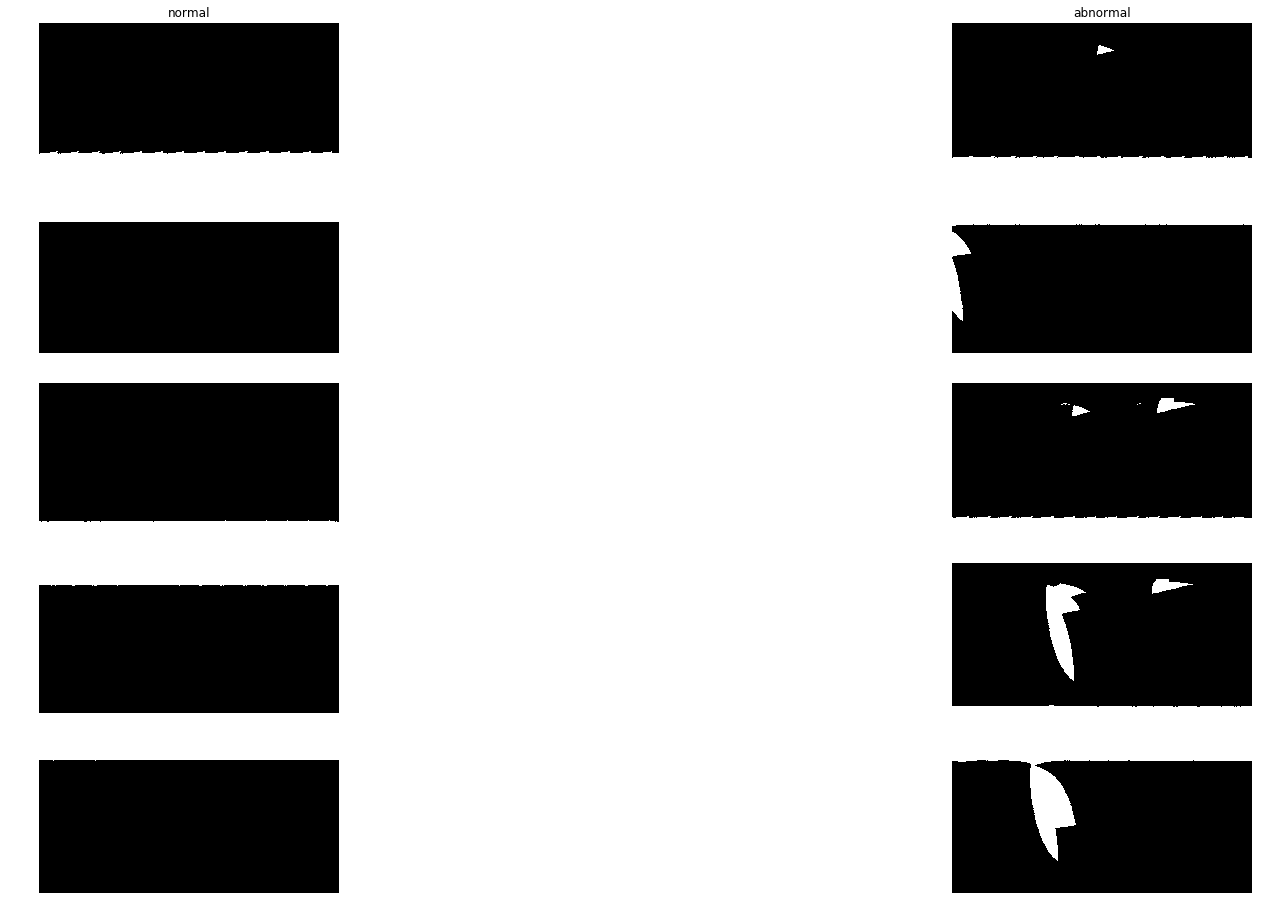

In [49]:
classes = ['normal', 'abnormal']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Extract Features
For each image we will compute a *Histogram of Oriented Gradients (HOG)* as well as a *color histogram* using the hue channel in HSV color space. We form our final feature vector for each image by concatenating the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring color information, and the color histogram represents the color of the input image while ignoring texture. As a result, we expect that using both together ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single image and return a feature vector for that image. The `extract_features` function takes a set of images and a list of feature functions and evaluates each feature function on each image, storing the results in a matrix where each column is the concatenation of all feature vectors for a single image.

In [4]:
from features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature] #, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# # Preprocessing: Divide by standard deviation. This ensures that each feature
# # has roughly the same scale.
# std_feat = np.std(X_train_feats, axis=0, keepdims=True)
# X_train_feats /= std_feat
# X_val_feats /= std_feat
# X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

print(X_train_feats.shape, X_val_feats.shape, X_test_feats.shape)

Done extracting features for 100 / 567 images
Done extracting features for 200 / 567 images
Done extracting features for 300 / 567 images
Done extracting features for 400 / 567 images
Done extracting features for 500 / 567 images
(567, 294913) (189, 294913) (190, 294913)


## Train Model

In [42]:
from models.linear_classifier import LinearSVM
from models.linear_classifier import Softmax

# Define the model
linear_classifier = Softmax()

# Hyperparameters
learning_rate = 1e-4
regularization_strength = 1e2

# Train the model
stats = linear_classifier.train(X_train_feats, y_train, X_val_feats, y_val,
                                learning_rate=learning_rate, reg=regularization_strength, 
                                num_iters=1000, verbose=True)

# Evaluate the model
y_train_prob, y_train_pred = linear_classifier.predict(X_train_feats)
y_val_prob, y_val_pred = linear_classifier.predict(X_val_feats)

training_accuracy = np.mean(y_train == y_train_pred)
validation_accuracy = np.mean(y_val == y_val_pred)

# Report the results
print('Training accuracy: ', training_accuracy)
print('Validation accuracy: ', validation_accuracy)

iteration 0 / 1000: loss 30.216090
iteration 100 / 1000: loss 4.578070
iteration 200 / 1000: loss 1.169792
iteration 300 / 1000: loss 0.705747
iteration 400 / 1000: loss 0.646839
iteration 500 / 1000: loss 0.637280
iteration 600 / 1000: loss 0.631308
iteration 700 / 1000: loss 0.639428
iteration 800 / 1000: loss 0.634287
iteration 900 / 1000: loss 0.632868
Training accuracy:  0.8483245149911817
Validation accuracy:  0.7037037037037037


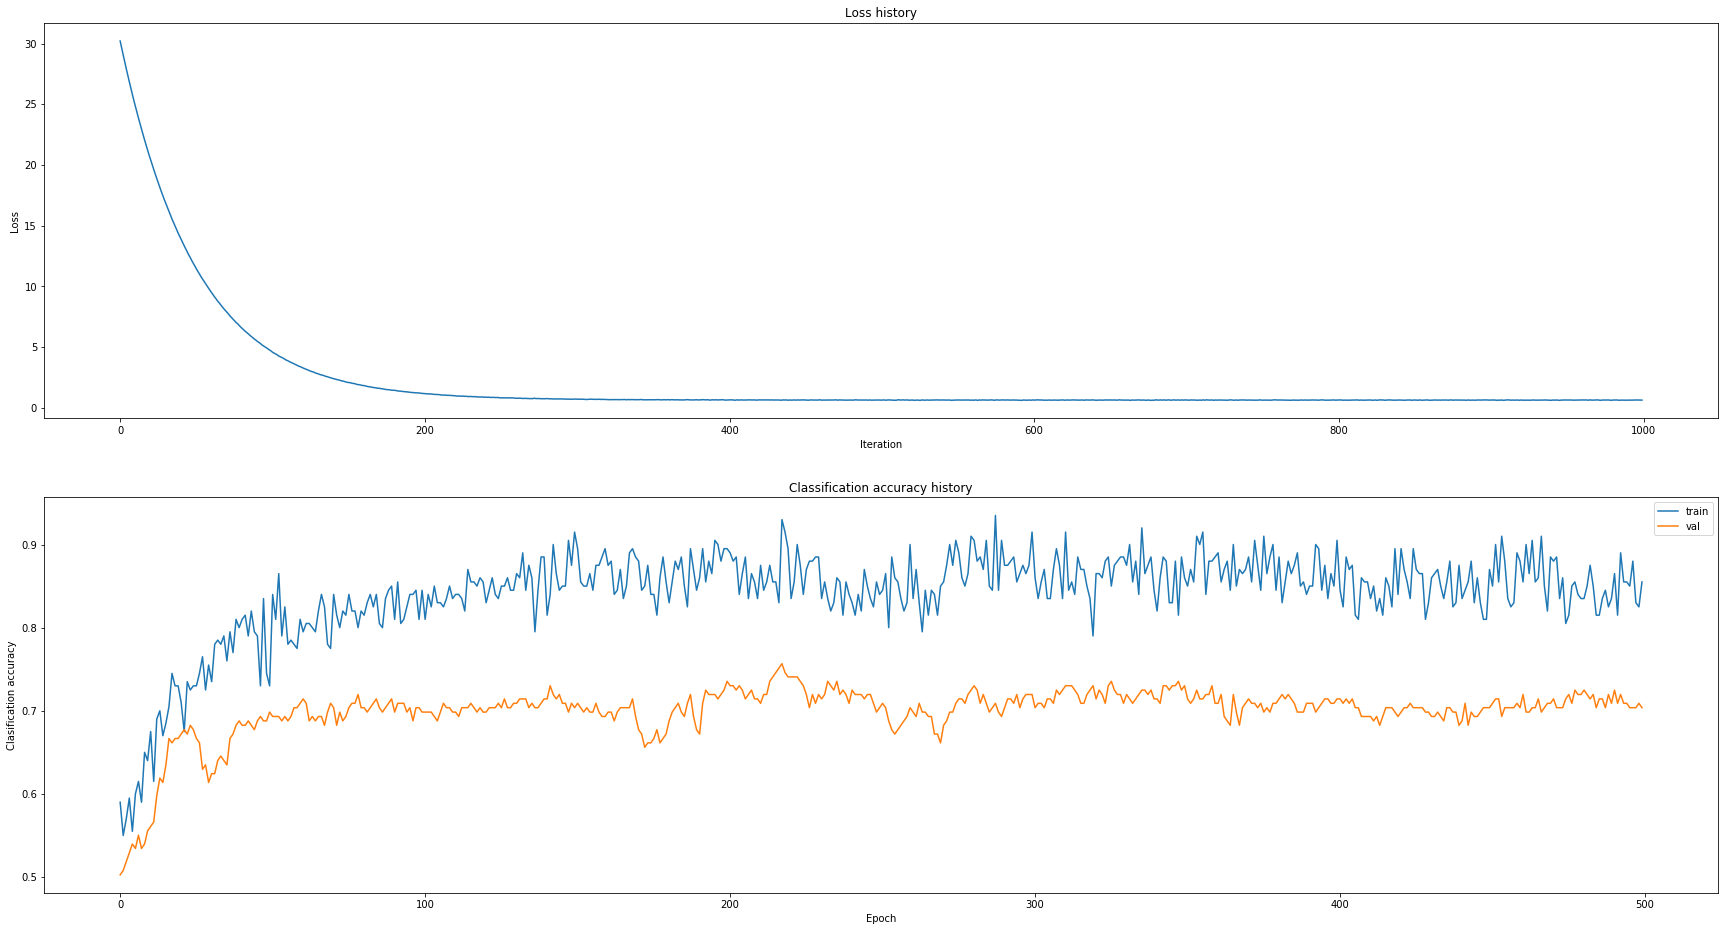

In [43]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [44]:
# Evaluate the trained linear classifier on the test set
_, y_test_pred = linear_classifier.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.7368421052631579


In [45]:
# # Visualize the cross-validation results
# import math
# x_scatter = [math.log10(x[0]) for x in results]
# y_scatter = [math.log10(x[1]) for x in results]

# # plot training accuracy
# marker_size = 100
# colors = [results[x][0] for x in results]
# plt.subplot(2, 1, 1)
# plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
# plt.colorbar()
# plt.xlabel('log learning rate')
# plt.ylabel('log regularization strength')
# plt.title('Training accuracy')

# # plot validation accuracy
# colors = [results[x][1] for x in results] # default size of markers is 20
# plt.subplot(2, 1, 2)
# plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
# plt.colorbar()
# plt.xlabel('log learning rate')
# plt.ylabel('log regularization strength')
# plt.title('Validation accuracy')
# plt.show()

In [46]:
# # Visualize the learned weights for each class.
# # Depending on your choice of learning rate and regularization strength, these may
# # or may not be nice to look at.
# w = best_classifier.W[:-1,:] # strip out the bias
# w = w.reshape(img_size[1], img_size[0], 3, num_classes)
# w_min, w_max = np.min(w), np.max(w)
# num_classes = len(classes)
# for i in range(num_classes):
#     plt.subplot(2, 5, i + 1)
      
#     # Rescale the weights to be between 0 and 255
#     wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
#     plt.imshow(wimg.astype('uint8'))
#     plt.axis('off')
#     plt.title(classes[i])

Accuracy: 70.37037037037037%
Non-normalized conf_matrix:
[[127.  44.]
 [ 12.   6.]]


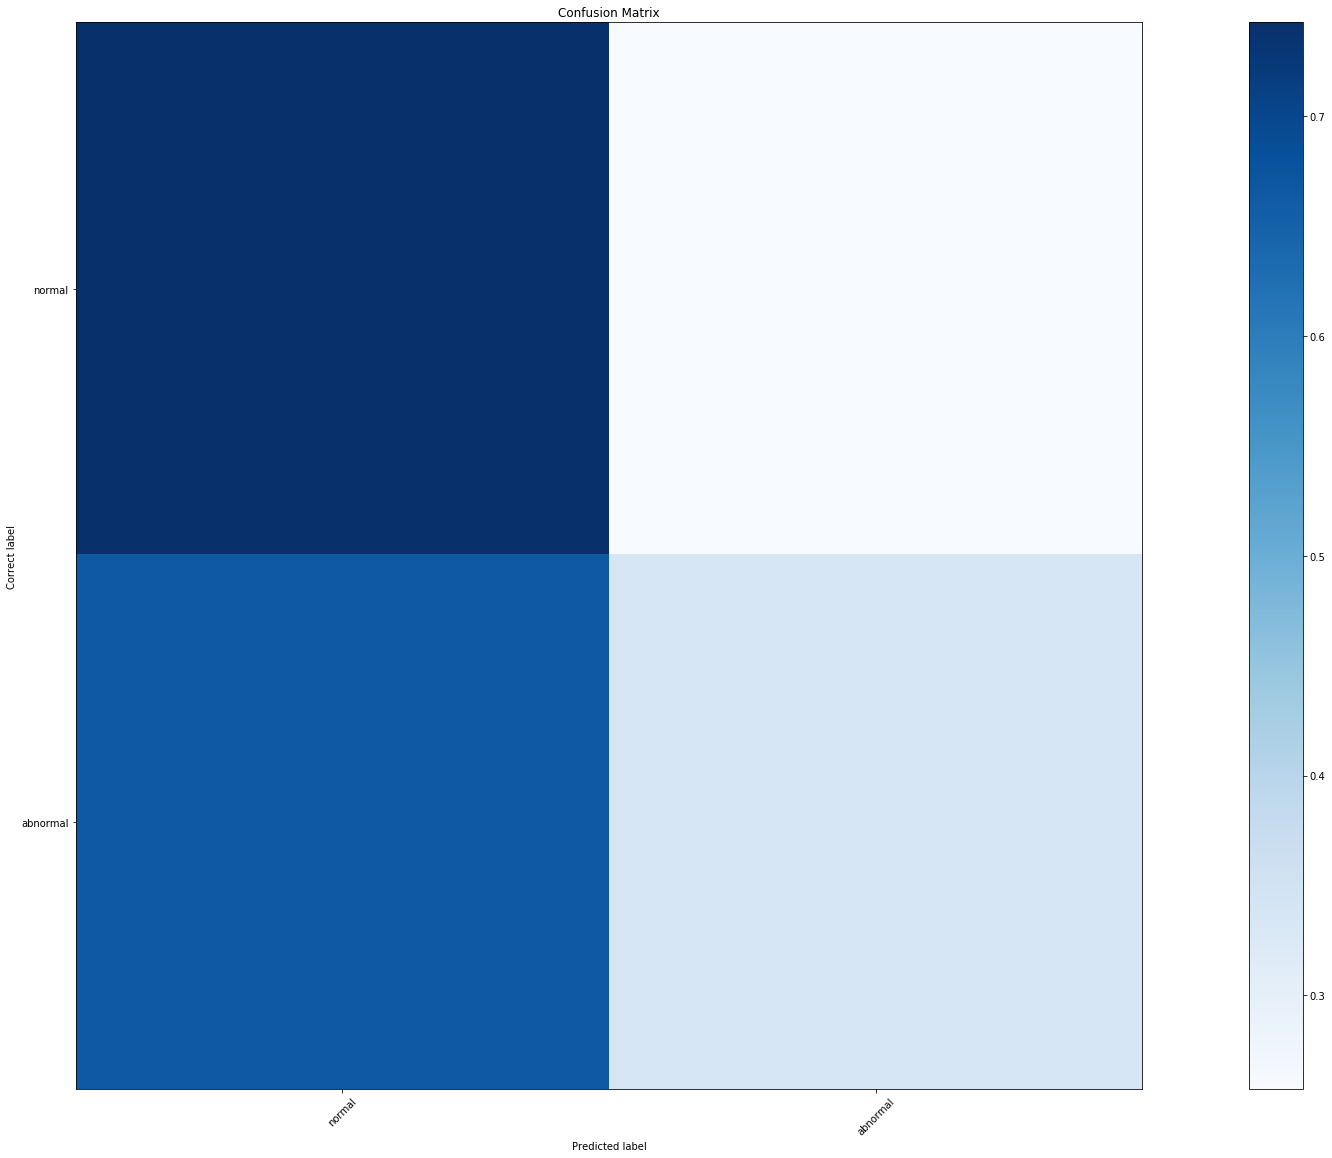

In [47]:
def confusion_matrix(results, categories, normalizeMatrix = True, plotConfusion=False):
    """ Generate confusion matrix
    - results = list of tuples of (correct label, predicted label)
    - categories = list of category names
    Returns confusion matrix; rows are correct labels and columns are predictions
    """
    # Empty confusion matrix
    matrix = np.zeros((len(categories),len(categories)))

    # Iterate over all labels and populate matrix
    for label, pred in results:
        matrix[label, pred] += 1

    # Print matrix and percent accuracy
    accuracy = float(np.trace(matrix)) * 100.0 / len(results)
    print('Accuracy: ' +  str(accuracy) + '%')

    # Normalize confusion matrix
    if normalizeMatrix:
      print("Non-normalized conf_matrix:")
      print(matrix)
      s = np.sum(matrix,1) # Sum each row
      for i in range(matrix.shape[0]):
        # Normalization handles class imbalance in training set
        matrix[i,:] /= s[i]

    # Save matrix to file:
    # np.save("confusion_matrix.npy",matrix)

    # Plot the confusion matrix
    if plotConfusion:
        plot_confusion_matrix(matrix, categories)

def plot_confusion_matrix(cm, names=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(4)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add labels to confusion matrix:
    if names is None:
        names = range(cm.shape[0])

    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Predicted label')
    plt.show()

confusion_matrix(list(zip(y_val, y_val_pred)), classes, plotConfusion=True)

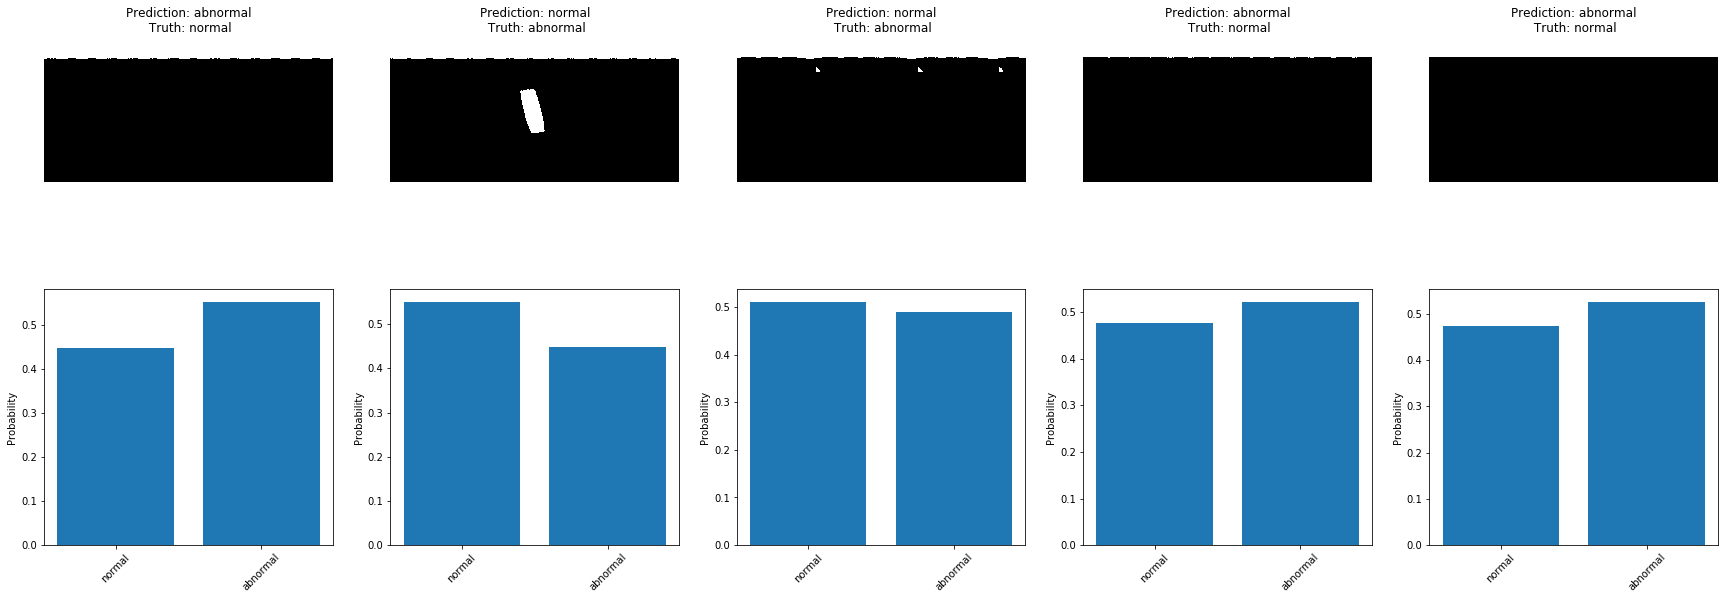

In [48]:
# Visualize misclassified examples from the validation dataset.
num_classes = len(classes)
max_examples = 5

incorrect_idx = [idx for idx, incorrect in enumerate(y_val != y_val_pred) if incorrect]
if len(incorrect_idx) > max_examples:
    incorrect_idx = incorrect_idx[:max_examples]
num_incorrect = len(incorrect_idx)

for y, idx in enumerate(incorrect_idx):
    for i in range(3):
        plt_idx = i * num_incorrect + y + 1
        if i == 0:
            plt.subplot(3, num_incorrect, plt_idx)
            plt.imshow(orig_X_val[idx].astype('uint8'))
            plt.axis('off')
            plt.title("Prediction: %s\n Truth: %s" % (classes[y_val_pred[idx]], classes[y_val[idx]]))
        elif i == 1:
            plt.subplot(3, num_incorrect, plt_idx)
            probabilities = y_val_prob[idx]
            y_pos = np.arange(len(classes))
            plt.bar(y_pos, probabilities)
            plt.xticks(y_pos, classes, rotation=45)
            plt.ylabel("Probability")
plt.show()